**Gestione Energetica ed Automazione negli Edifici (GEAE) A.A. 2024/2025**

*Tutto il materiale didattico messo a disposizione degli studenti (compresi script, markdown, presentazioni, video e Virtual Classroom) è da utilizzarsi esclusivamente per scopi didattici e nell’ambito del corso di “gestione energetica e automazione negli edifici”. È vietata ogni forma di utilizzo diverso, redistribuzione e pubblicazione on line. Per ogni eventuale dubbio o richiesta contattare il titolare del corso prof. Alfonso Capozzoli a alfonso.capozzoli@polito.it*

# Load Forecasting 1-step ahead with MLP

### Importing Libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

## Defining a robust MLP class

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', apply_relu_output=False):
        """
        Parameters:
        - input_size (int): The size of the input layer.
        - hidden_sizes (list of int): A list containing the sizes of each hidden layer.
        - output_size (int): The size of the output layer.
        - activation (str): The activation function for hidden layers ('relu' or 'tanh').
        - apply_relu_output (bool): Whether to apply ReLU to the output layer.
        """
        super(MLP, self).__init__()
        
        # Store activation function type
        if activation not in ['relu', 'tanh']:
            raise ValueError("Activation function must be either 'relu' or 'tanh'")
        self.activation = activation
        self.apply_relu_output = apply_relu_output

        # Create the list of layers
        layers = []
        previous_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            previous_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(previous_size, output_size))
        
        # Register the layers as a ModuleList
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Apply hidden layers with the chosen activation function
        for layer in self.layers[:-1]:
            x = layer(x)
            if self.activation == 'relu':
                x = torch.relu(x)
            elif self.activation == 'tanh':
                x = torch.tanh(x)
        
        # Apply the output layer
        x = self.layers[-1](x)
        
        # Optionally apply ReLU to the output layer
        if self.apply_relu_output:
            x = torch.relu(x)
        
        return x
    
    def predict(self, df):
        """
        Parameters:
        - df (pd.DataFrame): The input DataFrame containing the features.
        
        Returns:
        - np.ndarray: The prediction as a NumPy array.
        """
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            x = torch.tensor(df.values, dtype=torch.float32)
            output = self.forward(x)
        return np.array(output.numpy(), dtype=float)


This code defines an `MLP` class, a flexible multi-layer perceptron model in PyTorch. It allows customization of the network's architecture by specifying the input size, the sizes of hidden layers, and the output layer size. The model also supports the choice of activation function and optional application of ReLU to the output layer. Here is a detailed breakdown:

#### Class Definition and Initialization

- **Class `MLP(nn.Module)`**: This class inherits from PyTorch’s `nn.Module` to represent a customizable multi-layer perceptron model.
- **`__init__` Method**:
  - **Parameters**:
    - `input_size` (int): Number of neurons in the input layer.
    - `hidden_sizes` (list of int): List defining the number of neurons in each hidden layer.
    - `output_size` (int): Number of neurons in the output layer.
    - `activation` (str): Activation function for the hidden layers, with options `'relu'` or `'tanh'`.
    - `apply_relu_output` (bool): If set to `True`, applies a ReLU activation function to the output layer.

  - **Error Handling**:
    - If the specified `activation` function is not `'relu'` or `'tanh'`, a `ValueError` is raised.

  - **Layer Creation**:
    - Creates a sequence of linear layers:
      - For each hidden layer size in `hidden_sizes`, appends a linear layer.
      - Adds a final linear layer for the output.
    - **`nn.ModuleList`**: Layers are stored in a `ModuleList`, allowing them to be registered as model parameters.

#### Forward Pass

- **`forward(self, x)` Method**:
  - **Input** `x`: The input tensor.
  - **Hidden Layers**:
    - Iterates through all but the last layer in `self.layers`, applying each layer and the selected activation function (`ReLU` or `Tanh`).
  - **Output Layer**:
    - The final layer is applied to compute the model's output.
    - If `apply_relu_output` is `True`, ReLU is applied to the output layer.
  - **Returns**: The output tensor after all transformations.

#### Predict Method

- **`predict(self, df)` Method**:
  - **Parameters**:
    - `df` (pd.DataFrame): A DataFrame of input features for making predictions.
  - **Process**:
    - Sets the model to evaluation mode (`self.eval()`), which disables dropout and batch normalization, if present.
    - **`torch.no_grad()`** context is used to prevent gradient computation, saving memory and speeding up inference.
    - Converts the DataFrame to a tensor and feeds it through the `forward` method to get predictions.
  - **Returns**: The predictions as a NumPy array.


## Data Loading and Preparation

In [3]:
df = pd.read_csv('../data/data.csv', decimal=',', sep=';')

In [4]:
# normalize input features and target
df['P_norm'] = df['P'] / df['P'].max()

In [5]:
# split data into train and test sets based on year 2015 or 2016
# extract datetime from date and hour of original df
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Hour'].astype(str), format="%d/%m/%Y %H")
df['Year'] = pd.to_datetime(df['Date'], format='%d/%m/%Y').dt.year
train_df = df[df['Year'] == 2015].copy()
test_df = df[df['Year'] == 2016].copy()

In [6]:
def create_forecasting_datasets(data, lag_variables, forward_variables, static_variables=None, lag_steps=3, forward_steps=1):
    """
    Builds a dataset with lagged input features, forward-stepped outputs, and static features for time series forecasting.

    Parameters:
        data (pd.DataFrame): The original dataset containing time series data.
        lag_variables (list): List of column names used as lagged features.
        forward_variables (list): List of column names used as output features.
        static_variables (list, optional): List of column names to be included as-is without lagging or forwarding.
        lag_steps (int): Number of lagged steps for input features.
        forward_steps (int): Number of forward steps for outputs.

    Returns:
        pd.DataFrame: A DataFrame with lagged inputs, forward-stepped outputs, and static features.
    """
    
    # Initialize lists to store lagged, forward-stepped, and static columns
    lagged_data = []
    forward_data = []
    static_data = []

    # Generate lagged features for each input feature
    for feature in lag_variables:
        for lag in range(0, lag_steps):
            lagged_data.append(data[feature].shift(lag).rename(f'{feature}_lag_{lag}'))
    
    # Generate forward-stepped features for each output feature
    for feature in forward_variables:
        for step in range(1, forward_steps + 1):
            forward_data.append(data[feature].shift(-step).rename(f'{feature}_step_{step}'))
    
    # Add static features without any lagging or forwarding
    if static_variables:
        static_data = [data[feature] for feature in static_variables]
    
    # Concatenate the lagged, forward, and static data
    lagged_df = pd.concat(lagged_data, axis=1)
    forward_df = pd.concat(forward_data, axis=1)
    static_df = pd.concat(static_data, axis=1) if static_data else pd.DataFrame()
    
    # Combine all data
    result = pd.concat([lagged_df, static_df, forward_df], axis=1).dropna()
    
    return result


In [7]:
train_df_prepared = create_forecasting_datasets(train_df,
                                                lag_variables=['P_norm'],
                                                forward_variables=['P_norm'],
                                                lag_steps=4,
                                                forward_steps=1)
test_df_prepared = create_forecasting_datasets(test_df,
                                                lag_variables=['P_norm'],
                                                forward_variables=['P_norm'],
                                                lag_steps=4,
                                                forward_steps=1)

## MLP Model Training

### Define hyperparameters

In [8]:
batch_size = 128
hidden_sizes = [64, 64, 64]
activation = 'relu'
apply_relu_output = True
learning_rate = 0.001
epochs = 30


### Organize training data with PyTorch DataLoader

In [9]:
train_features = torch.FloatTensor(train_df_prepared.values[:, 0:4])
train_targets = torch.FloatTensor(train_df_prepared.values[:, 4:5])
dataset = TensorDataset(train_features, train_targets)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

`train_features = torch.FloatTensor(train_df_prepared.values[:, 0:4])`
- Extracts the first four columns from `train_df_prepared` as the features.
- Converts them to a PyTorch `FloatTensor` for model compatibility.

`train_targets = torch.FloatTensor(train_df_prepared.values[:, 4:5])`
- Extracts the fifth column from `train_df_prepared` as the target values.
- Converts them to a PyTorch `FloatTensor`.

`dataset = TensorDataset(train_features, train_targets)`
- Combines the feature and target tensors into a single dataset object.
- Allows for easy data handling and batch loading by PyTorch.

`train_loader = DataLoader(dataset, batch_size=32, shuffle=True)`
- Creates a DataLoader for iterating over `dataset` in mini-batches of 32.
- `shuffle=True` ensures the data is shuffled at the start of each epoch.

### Instantiate the model, define the loss function and the optimizer

In [10]:
model = MLP(4, hidden_sizes, 1, activation=activation, apply_relu_output=False)

In [11]:
# define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

`criterion = nn.MSELoss()`
- Sets the loss function to Mean Squared Error (MSE), commonly used for regression tasks.
- MSE measures the average squared difference between predicted and actual values, helping the model minimize prediction errors.

`optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)`
- Initializes the RMSprop optimizer with the model’s parameters and a specified learning rate (`learning_rate`).
- RMSprop is an adaptive learning rate optimization algorithm, useful for handling noisy gradients and improving model convergence.


### Train the model

In [12]:
# train the model
epochs = epochs

for epoch in range(epochs):
    epoch_loss = 0.0
    model.train()  # Set the model to training mode
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        optimizer.zero_grad()
        output = model(inputs)

        # Calculate loss
        loss = criterion(output, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the batch loss
        epoch_loss += loss.item()
    
    # Calculate and print the average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}')

Epoch 1/30, Average Loss: 0.0166
Epoch 2/30, Average Loss: 0.0035
Epoch 3/30, Average Loss: 0.0033
Epoch 4/30, Average Loss: 0.0033
Epoch 5/30, Average Loss: 0.0031
Epoch 6/30, Average Loss: 0.0029
Epoch 7/30, Average Loss: 0.0029
Epoch 8/30, Average Loss: 0.0028
Epoch 9/30, Average Loss: 0.0027
Epoch 10/30, Average Loss: 0.0026
Epoch 11/30, Average Loss: 0.0026
Epoch 12/30, Average Loss: 0.0026
Epoch 13/30, Average Loss: 0.0022
Epoch 14/30, Average Loss: 0.0024
Epoch 15/30, Average Loss: 0.0025
Epoch 16/30, Average Loss: 0.0024
Epoch 17/30, Average Loss: 0.0024
Epoch 18/30, Average Loss: 0.0022
Epoch 19/30, Average Loss: 0.0021
Epoch 20/30, Average Loss: 0.0023
Epoch 21/30, Average Loss: 0.0023
Epoch 22/30, Average Loss: 0.0025
Epoch 23/30, Average Loss: 0.0019
Epoch 24/30, Average Loss: 0.0022
Epoch 25/30, Average Loss: 0.0022
Epoch 26/30, Average Loss: 0.0021
Epoch 27/30, Average Loss: 0.0021
Epoch 28/30, Average Loss: 0.0023
Epoch 29/30, Average Loss: 0.0021
Epoch 30/30, Average Lo

`epochs = epochs`
- Sets the number of training epochs, controlling how many times the model will iterate over the entire dataset.

`for epoch in range(epochs):`
- Loops through each epoch, repeating the training process multiple times for improved model learning.

`epoch_loss = 0.0`
- Initializes the cumulative loss for each epoch, allowing calculation of the average loss at the end.

`model.train()`
- Sets the model to training mode, enabling behaviors like dropout (if any), which are only active during training.

`for batch_idx, (inputs, targets) in enumerate(train_loader):`
- Loops through mini-batches generated by `train_loader`, where `inputs` and `targets` are the feature and target tensors of each batch.

`optimizer.zero_grad()`
- Clears the gradients of all optimized parameters, preventing gradient accumulation from previous batches.

`output = model(inputs)`
- Performs a forward pass through the model, generating predictions for the input batch.

`loss = criterion(output, targets)`
- Calculates the loss between the model’s predictions (`output`) and actual target values (`targets`) using the specified loss function (`criterion`).

`loss.backward()`
- Performs backpropagation, calculating the gradients of the loss with respect to model parameters.

`optimizer.step()`
- Updates the model parameters based on the calculated gradients, moving them in the direction that minimizes the loss.

`epoch_loss += loss.item()`
- Accumulates the loss of each batch within the epoch.

`avg_epoch_loss = epoch_loss / len(train_loader)`
- Calculates the average loss for the epoch by dividing the cumulative epoch loss by the total number of batches.

`print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}')`
- Outputs the current epoch number and the average loss for the epoch, providing feedback on the model’s training progress.


## Model Evaluation

In [13]:
# assing the prediction to training data and testing data
train_df = train_df[train_df.index.isin(train_df_prepared.index)]
test_df = test_df[test_df.index.isin(test_df_prepared.index)]

train_df['prediction'] = model.predict(train_df_prepared.iloc[:,0:4])
test_df['prediction'] = model.predict(test_df_prepared.iloc[:,0:4])

### Calculate Metrics

In [14]:
# Calculate global metrics for the entire training set
global_metrics = {
    'Metric': ['Global MSE', 'Global MAPE', 'Global R2'],
    'Value': [
        float(mean_squared_error(train_df['P_norm'], train_df['prediction'])),
        float(mean_absolute_percentage_error(train_df['P_norm'], train_df['prediction'])),
        float(r2_score(train_df['P_norm'], train_df['prediction']))
    ]
}

global_metrics_df = pd.DataFrame(global_metrics)

global_metrics_test = {
    'Metric': ['Global Test MSE', 'Global Test MAPE', 'Global Test R2'],
    'Value': [
        float(mean_squared_error(test_df['P_norm'], test_df['prediction'])),
        float(mean_absolute_percentage_error(test_df['P_norm'], test_df['prediction'])),
        float(r2_score(test_df['P_norm'], test_df['prediction']))
    ]
}

global_metrics_test_df = pd.DataFrame(global_metrics_test)

print("\nGlobal Training Metrics:")
print(global_metrics_df)

print("\nGlobal Test Metrics:")
print(global_metrics_test_df)


Global Training Metrics:
        Metric     Value
0   Global MSE  0.004494
1  Global MAPE  0.118723
2    Global R2  0.920425

Global Test Metrics:
             Metric     Value
0   Global Test MSE  0.004623
1  Global Test MAPE  0.122261
2    Global Test R2  0.911287


### Rescale the prediction

In [15]:
# denormalize the prediction
train_df['prediction'] = train_df['prediction'] * df['P'].max()
test_df['prediction'] = test_df['prediction'] * df['P'].max()

### Plot original vs predicted series

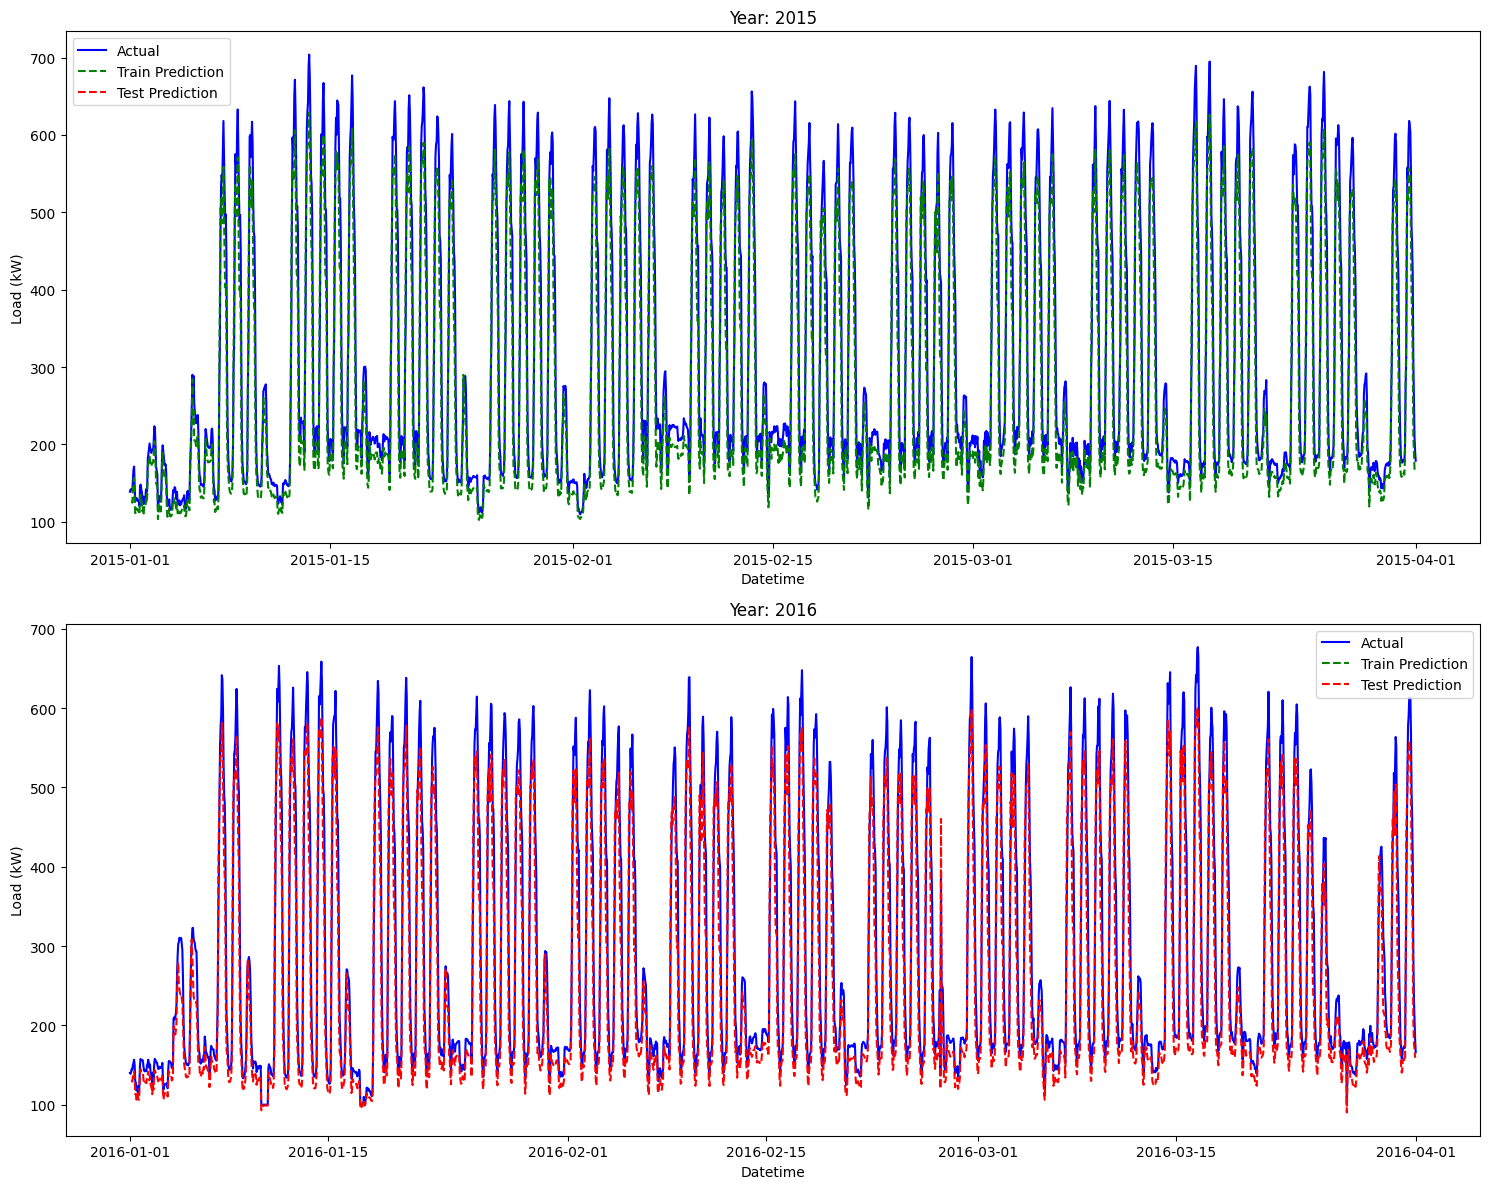

In [16]:
# Filter data for each year
years = df['Year'].unique()
fig, axs = plt.subplots(len(years), 1, figsize=(15, 6 * len(years)))

# Plot data for each year in separate subplots
for i, year in enumerate(years):
    ax = axs[i] if len(years) > 1 else axs  # Handle the case when there's only one subplot
    df_year = df[df['Year'] == year]
    train_year = train_df[train_df['Year'] == year]
    test_year = test_df[test_df['Year'] == year]

    ax.plot(df_year['datetime'], df_year['P'], label='Actual', color='blue')
    ax.plot(train_year['datetime'], train_year['prediction'], label='Train Prediction', linestyle='--', color='green')
    ax.plot(test_year['datetime'], test_year['prediction'], label='Test Prediction', linestyle='--', color='red')
    
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Load (kW)')
    ax.set_title(f'Year: {year}')
    ax.legend()

plt.tight_layout()



### Plot distribution of residuals

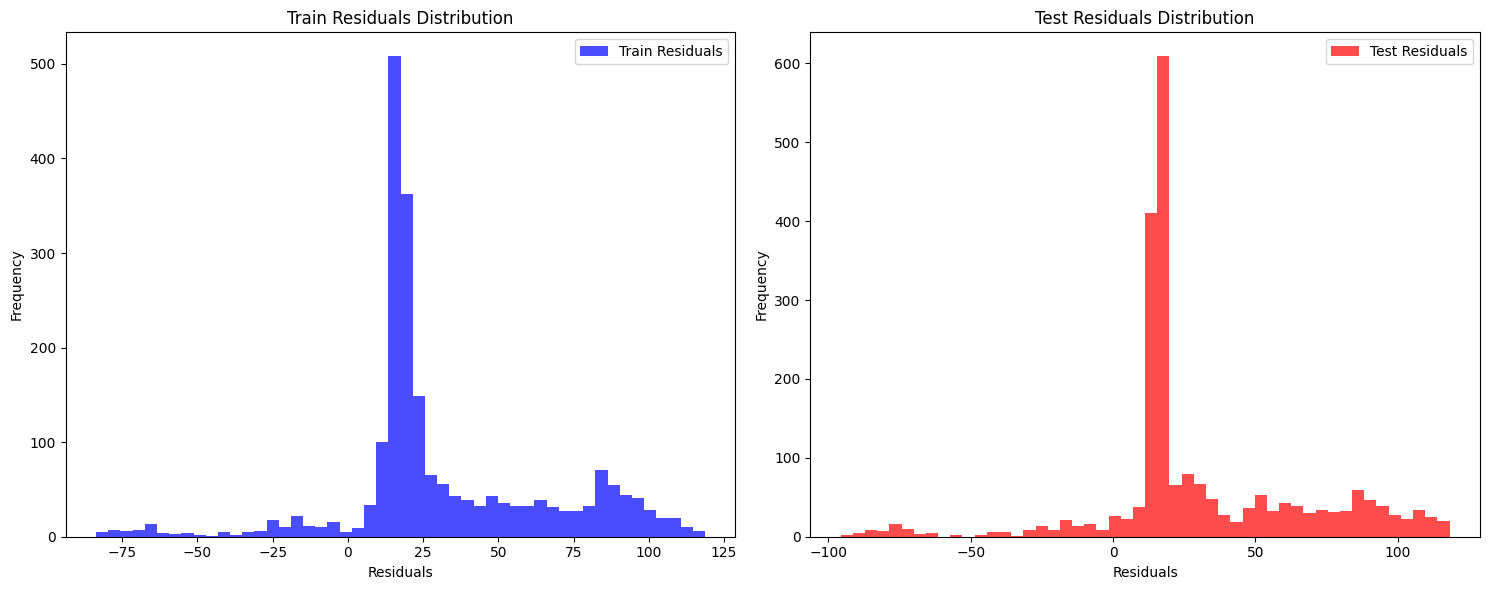

In [17]:
# plot residuals distribution
train_residuals = train_df['P'] - train_df['prediction']
test_residuals = test_df['P'] - test_df['prediction']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(train_residuals, bins=50, color='blue', alpha=0.7, label='Train Residuals')
axs[0].set_title('Train Residuals Distribution')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].hist(test_residuals, bins=50, color='red', alpha=0.7, label='Test Residuals')
axs[1].set_title('Test Residuals Distribution')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')
axs[1].legend()

plt.tight_layout()
